# Feature Engineering for Churn Prediction

**Author:** Harpinder Singh  
**Dataset:** UCI Online Retail II (UK E-Commerce)  
**Objective:** Engineer comprehensive features for supervised churn prediction

---

## Table of Contents
1. [Environment Setup](#1.-Environment-Setup)
2. [Load Data & CLV Predictions](#2.-Load-Data-&-CLV-Predictions)
3. [Define Churn](#3.-Define-Churn)
4. [RFM Features](#4.-RFM-Features)
5. [Probabilistic Features](#5.-Probabilistic-Features)
6. [Behavioral Velocity Features](#6.-Behavioral-Velocity-Features)
7. [Temporal Pattern Features](#7.-Temporal-Pattern-Features)
8. [Product Engagement Features](#8.-Product-Engagement-Features)
9. [Feature Summary & Export](#9.-Feature-Summary-&-Export)

---

## 1. Environment Setup

╔════════════════════════════════════════════════════════════════╗
║                    ENVIRONMENT CONFIGURATION                    ║
╚════════════════════════════════════════════════════════════════╝

In [1]:
# Standard imports
import warnings
from pathlib import Path
from datetime import datetime, timedelta

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environment configured")

✅ Environment configured


In [2]:
# ┌────────────────────────────────────────────────────────────┐
# │ Directory Setup                                            │
# └────────────────────────────────────────────────────────────┘

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DIR_DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DIR_MODELS = PROJECT_ROOT / 'models'
DIR_RESULTS = PROJECT_ROOT / 'results'
DIR_FIGURES = PROJECT_ROOT / 'results' / 'figures'

for directory in [DIR_MODELS, DIR_RESULTS, DIR_FIGURES]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Directories ready")

✅ Directories ready


---

## 2. Load Data & CLV Predictions

╔════════════════════════════════════════════════════════════════╗
║                      DATA LOADING                               ║
╚════════════════════════════════════════════════════════════════╝

In [3]:
# ┌────────────────────────────────────────────────────────────┐
# │ Load All Required Data                                     │
# └────────────────────────────────────────────────────────────┘

print("Loading data...\n")

# Training transactions
train_data = pd.read_csv(DIR_DATA_PROCESSED / 'train.csv', parse_dates=['InvoiceDate'])
print(f"✅ Training: {train_data.shape}")

# Validation transactions (for labeling churn)
val_data = pd.read_csv(DIR_DATA_PROCESSED / 'validation.csv', parse_dates=['InvoiceDate'])
print(f"✅ Validation: {val_data.shape}")

# CLV predictions from Phase 2
clv_preds = pd.read_csv(DIR_DATA_PROCESSED / 'customer_clv_predictions.csv')
print(f"✅ CLV predictions: {clv_preds.shape}")

# RFM features
rfm = pd.read_csv(DIR_DATA_PROCESSED / 'rfm_features.csv')
print(f"✅ RFM: {rfm.shape}")

print("\nTraining period: {} to {}".format(
    train_data['InvoiceDate'].min().date(),
    train_data['InvoiceDate'].max().date()
))
print("Validation period: {} to {}".format(
    val_data['InvoiceDate'].min().date(),
    val_data['InvoiceDate'].max().date()
))

Loading data...

✅ Training: (23942, 11)
✅ Validation: (330379, 11)
✅ CLV predictions: (815, 19)
✅ RFM: (815, 9)

Training period: 2010-12-01 to 2010-12-23
Validation period: 2011-01-04 to 2011-12-09


---

## 3. Define Churn

╔════════════════════════════════════════════════════════════════╗
║                      CHURN DEFINITION                          ║
╚════════════════════════════════════════════════════════════════╝

### Churn Definition Strategy:

**Operational Definition:**
- Customer is **churned** if no purchase in first 180 days of validation period
- Customer is **active** if at least 1 purchase in first 180 days

**Why 180 days?**
- Gives sufficient time for repeat purchase opportunity
- Balances class distribution (not too many/few churned)
- Business relevant (6-month horizon for intervention)

Churn labeling window:
  Start: 2011-01-04
  End (180 days): 2011-07-03

Churn Distribution:
Active (0): 596 (73.1%)
Churned (1): 219 (26.9%)


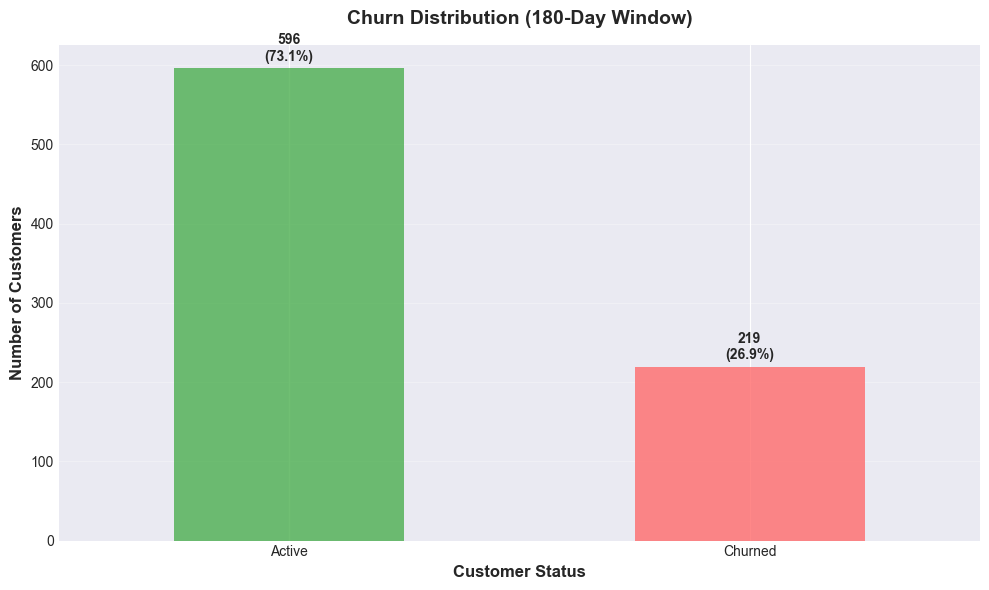

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Label Churn Based on Validation Period                     │
# └────────────────────────────────────────────────────────────┘

# Define churn window
val_start = val_data['InvoiceDate'].min()
churn_window_end = val_start + timedelta(days=180)

print(f"Churn labeling window:")
print(f"  Start: {val_start.date()}")
print(f"  End (180 days): {churn_window_end.date()}\n")

# Get customers who purchased in churn window
val_in_window = val_data[val_data['InvoiceDate'] <= churn_window_end]
active_customers = set(val_in_window['CustomerID'].unique())

# All training customers
all_train_customers = set(train_data['CustomerID'].unique())

# Label churn
churn_labels = pd.DataFrame({
    'CustomerID': list(all_train_customers),
    'churned': [1 if cid not in active_customers else 0 for cid in all_train_customers]
})

print("Churn Distribution:")
print("="*80)
churn_counts = churn_labels['churned'].value_counts()
print(f"Active (0): {churn_counts.get(0, 0)} ({churn_counts.get(0, 0)/len(churn_labels)*100:.1f}%)")
print(f"Churned (1): {churn_counts.get(1, 0)} ({churn_counts.get(1, 0)/len(churn_labels)*100:.1f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4CAF50', '#FF6B6B']
churn_counts.plot(kind='bar', ax=ax, color=colors, alpha=0.8)
ax.set_xlabel('Customer Status', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
ax.set_title('Churn Distribution (180-Day Window)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticklabels(['Active', 'Churned'], rotation=0)
ax.grid(axis='y', alpha=0.3)

# Add percentages
for i, v in enumerate(churn_counts.values):
    pct = v/len(churn_labels)*100
    ax.text(i, v + 10, f'{v}\n({pct:.1f}%)', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(DIR_FIGURES / '19_churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 4. RFM Features

╔════════════════════════════════════════════════════════════════╗
║                      RFM FEATURES                               ║
╚════════════════════════════════════════════════════════════════╝

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Traditional RFM Features (From Phase 1)                    │
# └────────────────────────────────────────────────────────────┘

# Start with RFM base
features = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Tenure', 
                'AvgOrderValue', 'AvgBasketSize']].copy()

# Add churn labels
features = features.merge(churn_labels, on='CustomerID', how='left')

print("Base RFM Features:")
print("="*80)
display(features.head())
print(f"\nTotal features so far: {len(features.columns) - 2}")  # -2 for CustomerID and churned

Base RFM Features:


,CustomerID,Recency,Frequency,Monetary,Tenure,AvgOrderValue,AvgBasketSize,churned
0,12747,10,2,706.2700,7,47.0847,14.2000,0
1,12748,0,35,4228.1300,22,6.3295,4.2530,0
2,12826,14,1,155.0000,0,17.2222,8.8889,0
3,12829,9,1,85.7500,0,17.1500,25.0000,0
4,12838,22,1,390.7900,0,6.6236,3.8644,1



Total features so far: 6


---

## 5. Probabilistic Features

╔════════════════════════════════════════════════════════════════╗
║                  PROBABILISTIC FEATURES                         ║
╚════════════════════════════════════════════════════════════════╝

### Features from BG/NBD + Gamma-Gamma models:
- Probability alive
- Predicted future purchases
- Predicted CLV
- Expected transaction value

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Add Probabilistic Features from Phase 2                    │
# └────────────────────────────────────────────────────────────┘

# Select relevant probabilistic features
prob_features = clv_preds[['CustomerID', 'prob_alive', 
                           'predicted_purchases_30d', 'predicted_purchases_90d',
                           'predicted_purchases_180d', 'predicted_avg_value',
                           'CLV_90d', 'CLV_180d', 'CLV_365d']].copy()

# Merge with main features
features = features.merge(prob_features, on='CustomerID', how='left')

print("After adding probabilistic features:")
print("="*80)
print(f"Total features: {len(features.columns) - 2}")
print(f"\nNew features added:")
for col in prob_features.columns:
    if col != 'CustomerID':
        print(f"  • {col}")

After adding probabilistic features:
Total features: 14

New features added:
  • prob_alive
  • predicted_purchases_30d
  • predicted_purchases_90d
  • predicted_purchases_180d
  • predicted_avg_value
  • CLV_90d
  • CLV_180d
  • CLV_365d


---

## 6. Behavioral Velocity Features

╔════════════════════════════════════════════════════════════════╗
║               BEHAVIORAL VELOCITY FEATURES                      ║
╚════════════════════════════════════════════════════════════════╝

### Key Idea:
**Rate of change** matters more than absolute values!

### Examples:
- Is spending **increasing** or **decreasing**?
- Are purchase gaps **growing** or **shrinking**?
- Is basket size **trending up** or **down**?

### Implementation:
Compare recent behavior vs. historical average

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Calculate Behavioral Velocity Features                     │
# └────────────────────────────────────────────────────────────┘

# Need per-customer transaction history
train_reference_date = train_data['InvoiceDate'].max()

# Split transactions into early (first 50%) and late (last 50%) periods
train_data_sorted = train_data.sort_values(['CustomerID', 'InvoiceDate'])

velocity_features = []

for customer_id in train_data['CustomerID'].unique():
    cust_data = train_data_sorted[train_data_sorted['CustomerID'] == customer_id]
    
    n_transactions = len(cust_data)
    
    # Split into early and late periods
    split_point = n_transactions // 2
    early = cust_data.iloc[:split_point] if split_point > 0 else cust_data
    late = cust_data.iloc[split_point:] if split_point > 0 else cust_data
    
    # Calculate metrics for each period
    early_avg_revenue = early['Revenue'].mean() if len(early) > 0 else 0
    late_avg_revenue = late['Revenue'].mean() if len(late) > 0 else 0
    
    early_avg_qty = early['Quantity'].mean() if len(early) > 0 else 0
    late_avg_qty = late['Quantity'].mean() if len(late) > 0 else 0
    
    # Calculate velocity (trend)
    revenue_velocity = (late_avg_revenue - early_avg_revenue) / (early_avg_revenue + 1)  # +1 to avoid div by 0
    quantity_velocity = (late_avg_qty - early_avg_qty) / (early_avg_qty + 1)
    
    # Time between purchases trend
    if len(cust_data) >= 2:
        cust_data_time = cust_data.sort_values('InvoiceDate')
        time_diffs = cust_data_time['InvoiceDate'].diff().dt.days.dropna()
        
        if len(time_diffs) >= 2:
            early_diffs = time_diffs[:len(time_diffs)//2]
            late_diffs = time_diffs[len(time_diffs)//2:]
            
            early_gap = early_diffs.mean() if len(early_diffs) > 0 else 0
            late_gap = late_diffs.mean() if len(late_diffs) > 0 else 0
            
            gap_velocity = (late_gap - early_gap) / (early_gap + 1)
        else:
            gap_velocity = 0
    else:
        gap_velocity = 0
    
    velocity_features.append({
        'CustomerID': customer_id,
        'revenue_velocity': revenue_velocity,
        'quantity_velocity': quantity_velocity,
        'purchase_gap_velocity': gap_velocity,
        'early_period_revenue': early_avg_revenue,
        'late_period_revenue': late_avg_revenue,
        'revenue_trend': 1 if revenue_velocity > 0 else 0  # Binary: increasing or not
    })

velocity_df = pd.DataFrame(velocity_features)

# Merge with main features
features = features.merge(velocity_df, on='CustomerID', how='left')

print("Behavioral Velocity Features:")
print("="*80)
display(features[['CustomerID', 'revenue_velocity', 'quantity_velocity', 
                  'purchase_gap_velocity', 'revenue_trend']].head(10))

print(f"\nTotal features: {len(features.columns) - 2}")

Behavioral Velocity Features:


,CustomerID,revenue_velocity,quantity_velocity,purchase_gap_velocity,revenue_trend
0,12747,-0.1486,-0.1402,-0.5000,0
1,12748,0.4229,0.3487,0.0148,1
2,12826,0.1323,-0.1048,0.0000,1
3,12829,-0.4023,15.6667,0.0000,0
4,12838,0.2154,-0.2541,0.0000,1
5,12839,0.2092,0.1264,0.5556,1
6,12841,-0.2419,-0.1861,0.0870,0
7,12855,-0.4011,0.8571,0.0000,0
8,12867,-0.0377,-0.0409,0.0000,0
9,12868,0.0321,1.3514,0.0000,1



Total features: 20


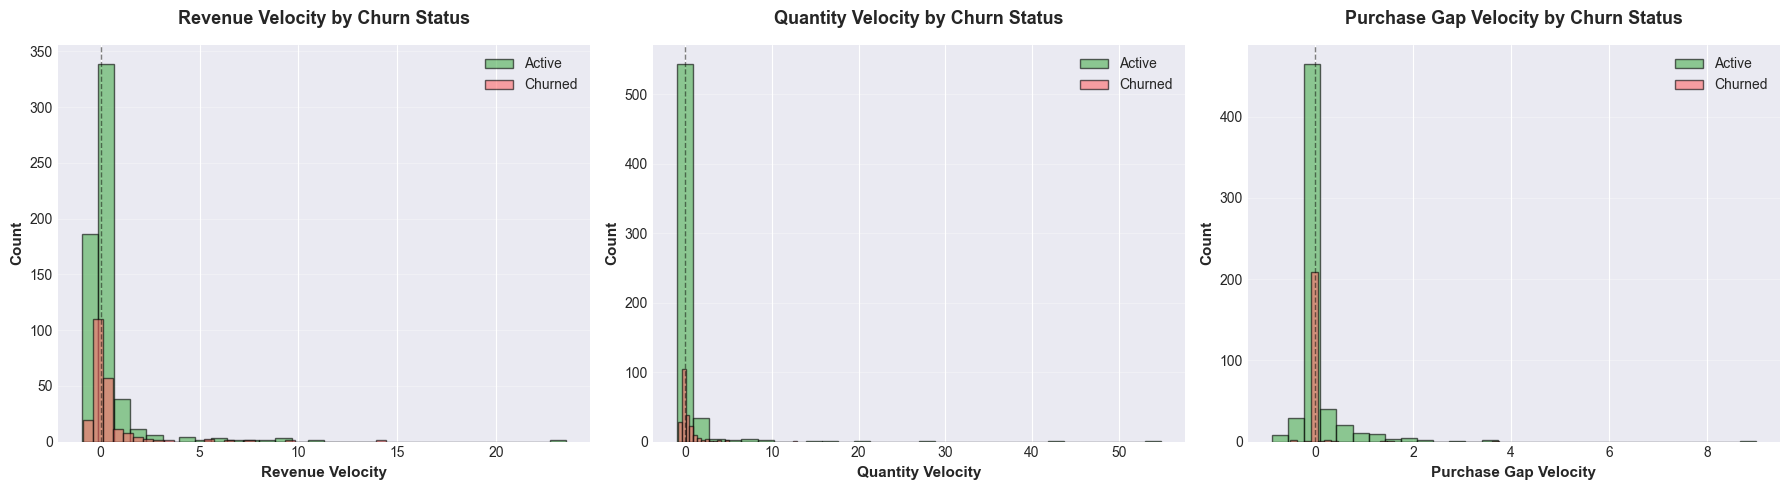

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize Velocity Features by Churn Status                │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Revenue velocity
for churn_status in [0, 1]:
    data = features[features['churned'] == churn_status]['revenue_velocity']
    label = 'Active' if churn_status == 0 else 'Churned'
    color = '#4CAF50' if churn_status == 0 else '#FF6B6B'
    axes[0].hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

axes[0].set_xlabel('Revenue Velocity', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_title('Revenue Velocity by Churn Status', fontsize=13, fontweight='bold', pad=15)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Quantity velocity
for churn_status in [0, 1]:
    data = features[features['churned'] == churn_status]['quantity_velocity']
    label = 'Active' if churn_status == 0 else 'Churned'
    color = '#4CAF50' if churn_status == 0 else '#FF6B6B'
    axes[1].hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

axes[1].set_xlabel('Quantity Velocity', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1].set_title('Quantity Velocity by Churn Status', fontsize=13, fontweight='bold', pad=15)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Purchase gap velocity
for churn_status in [0, 1]:
    data = features[features['churned'] == churn_status]['purchase_gap_velocity']
    label = 'Active' if churn_status == 0 else 'Churned'
    color = '#4CAF50' if churn_status == 0 else '#FF6B6B'
    axes[2].hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

axes[2].set_xlabel('Purchase Gap Velocity', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[2].set_title('Purchase Gap Velocity by Churn Status', fontsize=13, fontweight='bold', pad=15)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '20_velocity_features.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 7. Temporal Pattern Features

╔════════════════════════════════════════════════════════════════╗
║                  TEMPORAL PATTERN FEATURES                      ║
╚════════════════════════════════════════════════════════════════╝

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Calculate Temporal Patterns                                │
# └────────────────────────────────────────────────────────────┘

temporal_features = []

for customer_id in train_data['CustomerID'].unique():
    cust_data = train_data[train_data['CustomerID'] == customer_id].copy()
    
    # Days of week pattern
    cust_data['DayOfWeek'] = cust_data['InvoiceDate'].dt.dayofweek
    dow_diversity = cust_data['DayOfWeek'].nunique()
    weekend_purchases = ((cust_data['DayOfWeek'] >= 5).sum() / len(cust_data)) if len(cust_data) > 0 else 0
    
    # Time between purchases statistics
    if len(cust_data) >= 2:
        time_gaps = cust_data.sort_values('InvoiceDate')['InvoiceDate'].diff().dt.days.dropna()
        gap_mean = time_gaps.mean() if len(time_gaps) > 0 else 0
        gap_std = time_gaps.std() if len(time_gaps) > 1 else 0
        gap_cv = gap_std / (gap_mean + 1)  # Coefficient of variation
    else:
        gap_mean = 0
        gap_std = 0
        gap_cv = 0
    
    temporal_features.append({
        'CustomerID': customer_id,
        'day_of_week_diversity': dow_diversity,
        'weekend_purchase_ratio': weekend_purchases,
        'purchase_gap_mean': gap_mean,
        'purchase_gap_std': gap_std,
        'purchase_gap_cv': gap_cv,
        'purchase_regularity': 1 if gap_cv < 0.5 else 0  # Low CV = regular
    })

temporal_df = pd.DataFrame(temporal_features)

# Merge
features = features.merge(temporal_df, on='CustomerID', how='left')

print("Temporal Pattern Features:")
print("="*80)
display(features[['CustomerID', 'day_of_week_diversity', 'weekend_purchase_ratio',
                  'purchase_gap_mean', 'purchase_gap_cv', 'purchase_regularity']].head(10))

print(f"\nTotal features: {len(features.columns) - 2}")

Temporal Pattern Features:


,CustomerID,day_of_week_diversity,weekend_purchase_ratio,purchase_gap_mean,purchase_gap_cv,purchase_regularity
0,12747,2,0.4667,0.5000,1.2472,0
1,12748,6,0.2904,0.0165,0.2046,1
2,12826,1,0.0000,0.0000,0.0000,1
3,12829,1,0.0000,0.0000,0.0000,1
4,12838,1,0.0000,0.0000,0.0000,1
5,12839,2,0.0000,0.2778,1.3043,0
6,12841,2,0.4894,0.0435,0.2826,1
7,12855,1,0.0000,0.0000,0.0000,1
8,12867,1,0.0000,0.0000,0.0000,1
9,12868,1,0.0000,0.0000,0.0000,1



Total features: 26


---

## 8. Product Engagement Features

╔════════════════════════════════════════════════════════════════╗
║                PRODUCT ENGAGEMENT FEATURES                      ║
╚════════════════════════════════════════════════════════════════╝

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Calculate Product Engagement Metrics                       │
# └────────────────────────────────────────────────────────────┘

product_features = []

for customer_id in train_data['CustomerID'].unique():
    cust_data = train_data[train_data['CustomerID'] == customer_id]
    
    # Product diversity
    unique_products = cust_data['StockCode'].nunique()
    total_items = cust_data['Quantity'].sum()
    unique_invoices = cust_data['InvoiceNo'].nunique()
    
    # Average items per purchase
    avg_items_per_purchase = total_items / unique_invoices if unique_invoices > 0 else 0
    
    # Product exploration (new products over time)
    if len(cust_data) >= 2:
        sorted_data = cust_data.sort_values('InvoiceDate')
        first_half_products = set(sorted_data.iloc[:len(sorted_data)//2]['StockCode'].unique())
        second_half_products = set(sorted_data.iloc[len(sorted_data)//2:]['StockCode'].unique())
        new_products = len(second_half_products - first_half_products)
        product_exploration = new_products / (len(first_half_products) + 1)
    else:
        product_exploration = 0
    
    product_features.append({
        'CustomerID': customer_id,
        'unique_products': unique_products,
        'avg_items_per_order': avg_items_per_purchase,
        'product_diversity_ratio': unique_products / total_items if total_items > 0 else 0,
        'product_exploration_rate': product_exploration
    })

product_df = pd.DataFrame(product_features)

# Merge
features = features.merge(product_df, on='CustomerID', how='left')

print("Product Engagement Features:")
print("="*80)
display(features[['CustomerID', 'unique_products', 'avg_items_per_order',
                  'product_diversity_ratio', 'product_exploration_rate']].head(10))

print(f"\nTotal features: {len(features.columns) - 2}")

Product Engagement Features:


,CustomerID,unique_products,avg_items_per_order,product_diversity_ratio,product_exploration_rate
0,12747,12,106.5000,0.0563,0.6250
1,12748,493,81.1714,0.1735,0.8162
2,12826,9,80.0000,0.1125,1.0000
3,12829,5,125.0000,0.0400,1.0000
4,12838,59,228.0000,0.2588,1.0000
5,12839,29,219.0000,0.0662,0.5789
6,12841,43,160.5000,0.1340,0.8333
7,12855,3,30.0000,0.1000,1.0000
8,12867,53,377.0000,0.1406,1.0000
9,12868,12,112.0000,0.1071,0.8571



Total features: 30


---

## 9. Feature Summary & Export

╔════════════════════════════════════════════════════════════════╗
║                  FEATURE SUMMARY & EXPORT                       ║
╚════════════════════════════════════════════════════════════════╝

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Feature Summary Statistics                                 │
# └────────────────────────────────────────────────────────────┘

# Separate features from target
feature_cols = [col for col in features.columns if col not in ['CustomerID', 'churned']]

print("Feature Engineering Summary:")
print("="*80)
print(f"\nTotal customers: {len(features):,}")
print(f"Total features: {len(feature_cols)}")
print(f"Churn rate: {features['churned'].mean()*100:.1f}%")

print("\nFeature Categories:")
print("  • RFM: 6 features (Recency, Frequency, Monetary, Tenure, AvgOrderValue, AvgBasketSize)")
print("  • Probabilistic: 8 features (prob_alive, predicted purchases, CLV forecasts)")
print("  • Velocity: 6 features (revenue/quantity/gap velocity, trends)")
print("  • Temporal: 6 features (day diversity, gaps, regularity)")
print("  • Product: 4 features (diversity, exploration, items per order)")

# Check for missing values
missing = features[feature_cols].isnull().sum()
if missing.sum() > 0:
    print("\n⚠️ Missing values detected:")
    print(missing[missing > 0])
    # Fill with 0 or median
    features[feature_cols] = features[feature_cols].fillna(0)
    print("✅ Missing values filled with 0")
else:
    print("\n✅ No missing values")

# Check data types
print("\nFeature dtypes:")
print(features[feature_cols].dtypes.value_counts())

Feature Engineering Summary:

Total customers: 815
Total features: 30
Churn rate: 26.9%

Feature Categories:
  • RFM: 6 features (Recency, Frequency, Monetary, Tenure, AvgOrderValue, AvgBasketSize)
  • Probabilistic: 8 features (prob_alive, predicted purchases, CLV forecasts)
  • Velocity: 6 features (revenue/quantity/gap velocity, trends)
  • Temporal: 6 features (day diversity, gaps, regularity)
  • Product: 4 features (diversity, exploration, items per order)

✅ No missing values

Feature dtypes:
float64    23
int64       7
Name: count, dtype: int64


Top 15 Features Correlated with Churn:
prob_alive                  0.2444
purchase_regularity         0.2214
Recency                     0.1854
product_diversity_ratio     0.1245
AvgBasketSize               0.0263
revenue_velocity            0.0193
predicted_avg_value         0.0018
late_period_revenue        -0.0067
AvgOrderValue              -0.0181
quantity_velocity          -0.0286
early_period_revenue       -0.0303
revenue_trend              -0.0316
weekend_purchase_ratio     -0.0341
product_exploration_rate   -0.0364
purchase_gap_velocity      -0.0636
Name: churned, dtype: float64

Bottom 15 Features (Negative Correlation with Churn):
avg_items_per_order        -0.0685
Frequency                  -0.1048
unique_products            -0.1067
purchase_gap_mean          -0.1159
Monetary                   -0.1232
CLV_365d                   -0.1302
CLV_180d                   -0.1302
CLV_90d                    -0.1302
purchase_gap_std           -0.1819
day_of_week_diversity      -0.2033
p

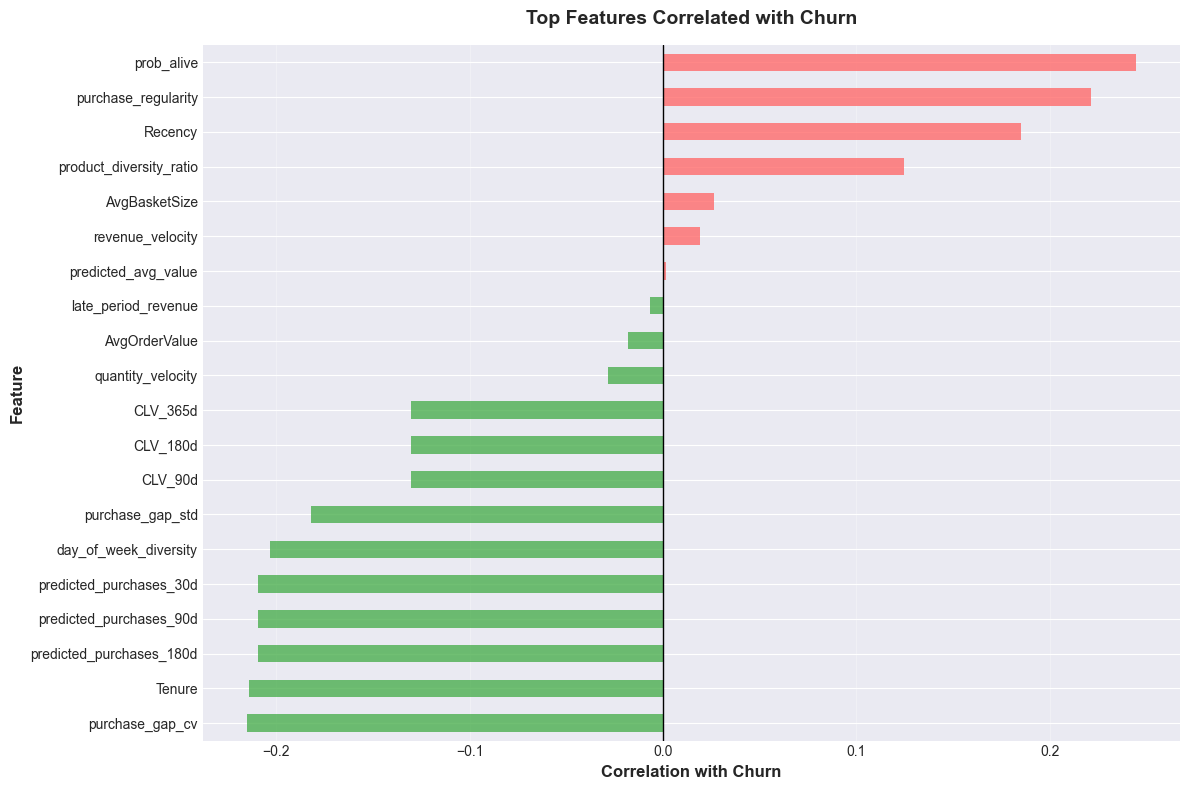

In [ ]:
# ┌────────────────────────────────────────────────────────────┐
# │ Correlation with Churn                                     │
# └────────────────────────────────────────────────────────────┘

# Calculate correlation with target
correlations = features[feature_cols + ['churned']].corr()['churned'].drop('churned').sort_values(ascending=False)

print("Top 15 Features Correlated with Churn:")
print("="*80)
print(correlations.head(15))

print("\nBottom 15 Features (Negative Correlation with Churn):")
print("="*80)
print(correlations.tail(15))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
top_features = pd.concat([correlations.head(10), correlations.tail(10)]).sort_values()
colors = ['#FF6B6B' if x > 0 else '#4CAF50' for x in top_features.values]
top_features.plot(kind='barh', ax=ax, color=colors, alpha=0.8)
ax.set_xlabel('Correlation with Churn', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top Features Correlated with Churn', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)
ax.axvline(0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.savefig(DIR_FIGURES / '21_feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# ┌────────────────────────────────────────────────────────────┐
# │ Export Feature Dataset                                     │
# └────────────────────────────────────────────────────────────┘

# Save complete feature set
features.to_csv(DIR_DATA_PROCESSED / 'churn_features.csv', index=False)
print("✅ Features saved to: churn_features.csv")
print(f"   Shape: {features.shape}")

# Save feature list for reference
feature_list = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [correlations.get(f, 0) for f in feature_cols]
}).sort_values('Correlation', key=abs, ascending=False)

feature_list.to_csv(DIR_RESULTS / 'outputs' / 'feature_importance.csv', index=False)
print("✅ Feature list saved to: feature_importance.csv")

# Summary report
summary = pd.DataFrame({
    'Metric': [
        'Total Customers',
        'Total Features',
        'Churn Rate (%)',
        'Active Customers',
        'Churned Customers',
        'Top Positive Correlation',
        'Top Negative Correlation'
    ],
    'Value': [
        len(features),
        len(feature_cols),
        f"{features['churned'].mean()*100:.1f}%",
        (features['churned'] == 0).sum(),
        (features['churned'] == 1).sum(),
        f"{correlations.index[0]}: {correlations.iloc[0]:.3f}",
        f"{correlations.index[-1]}: {correlations.iloc[-1]:.3f}"
    ]
})

summary.to_csv(DIR_RESULTS / 'outputs' / 'feature_summary.csv', index=False)
print("✅ Summary saved to: feature_summary.csv")

print("\n" + "="*80)
display(summary)
print("="*80)

✅ Features saved to: churn_features.csv
   Shape: (815, 32)
✅ Feature list saved to: feature_importance.csv
✅ Summary saved to: feature_summary.csv



,Metric,Value
0,Total Customers,815
1,Total Features,30
2,Churn Rate (%),26.9%
3,Active Customers,596
4,Churned Customers,219
5,Top Positive Correlation,prob_alive: 0.244
6,Top Negative Correlation,purchase_gap_cv: -0.215


In [16]:
# ┌────────────────────────────────────────────────────────────┐
# │ Final Summary                                              │
# └────────────────────────────────────────────────────────────┘

print("\n" + "═"*80)
print("FEATURE ENGINEERING COMPLETE")
print("═"*80)

print("\n✅ Features Engineered:")
print(f"   • {len(feature_cols)} total features across 5 categories")
print(f"   • {len(features):,} customers labeled for churn")

print("\n✅ Outputs Created:")
print("   • data/processed/churn_features.csv")
print("   • results/feature_importance.csv")
print("   • results/feature_summary.csv")
print("   • results/figures/ (3 new visualizations)")

print("\n✅ Ready for:")
print("   • Supervised churn modeling (6 algorithms)")
print("   • Feature selection & importance analysis")
print("   • Model comparison & hyperparameter tuning")

print("\n" + "═"*80)


════════════════════════════════════════════════════════════════════════════════
FEATURE ENGINEERING COMPLETE
════════════════════════════════════════════════════════════════════════════════

✅ Features Engineered:
   • 30 total features across 5 categories
   • 815 customers labeled for churn

✅ Outputs Created:
   • data/processed/churn_features.csv
   • results/feature_importance.csv
   • results/feature_summary.csv
   • results/figures/ (3 new visualizations)

✅ Ready for:
   • Supervised churn modeling (6 algorithms)
   • Feature selection & importance analysis
   • Model comparison & hyperparameter tuning

════════════════════════════════════════════════════════════════════════════════
